In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from ycbv_loader import YCBVDataset

In [2]:
class YCBVConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'ycb'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 21
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    TRAIN_ROIS_PER_IMAGE = 100
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
config = YCBVConfig()
# config.display()

In [3]:
data_dir = os.path.join(ROOT_DIR, 'randomized_data')
dataset_train = YCBVDataset(data_dir, split='train')
dataset_train.load_ycbv()
dataset_train.prepare()

In [4]:
def display_rgb_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[np.where(class_ids == i)[0], :, :, :])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        m_id = np.where(class_ids == class_id)[0][0]
        m = mask[m_id, :, :, :]
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    visualize.display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

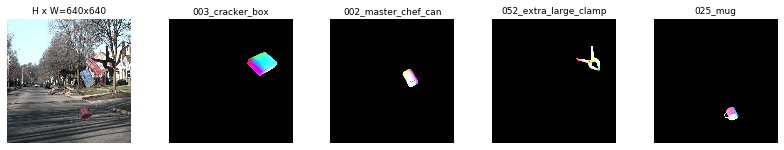

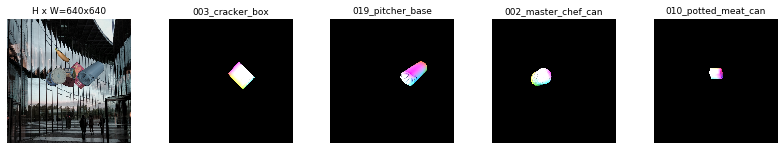

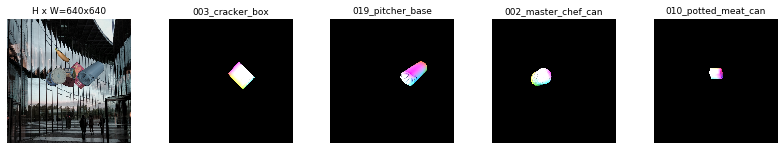

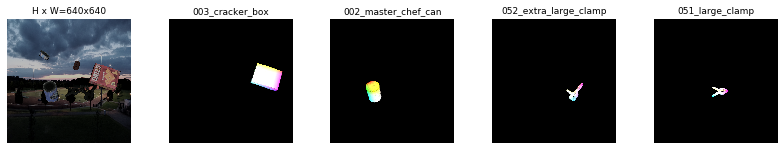

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    masks, class_ids = dataset_train.load_rgb_mask(image_id)
    visualize.display_rgb_top_masks(image, masks, class_ids, dataset_train.class_names)

In [6]:
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours

image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (7, 640, 640, 3)      min:    0.00000  max:    1.00000  float64
class_ids                shape: (7,)                  min:    2.00000  max:   21.00000  int32
bbox                     shape: (7, 4)                min:  137.00000  max:  479.00000  int32


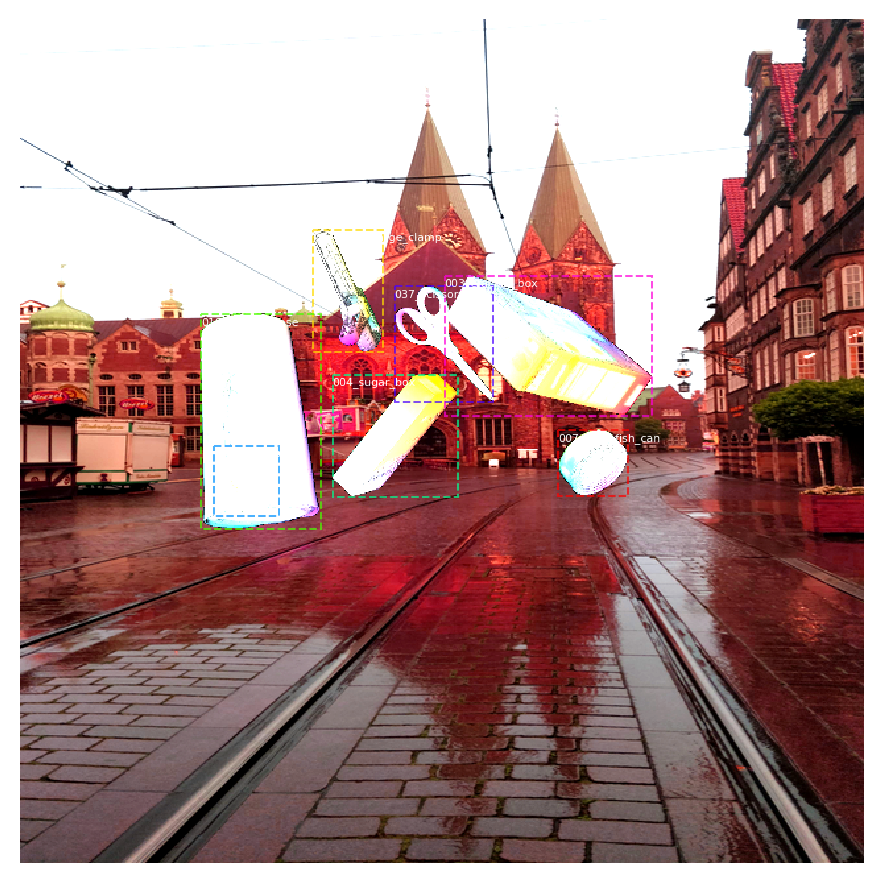

In [17]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image, _, class_id, bbox, mask = modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
# image = dataset_train.load_image(image_id)
# mask, class_ids = dataset_train.load_rgb_mask(image_id)
# Compute Bounding box
# bbox = utils.extract_bboxes(mask)
# Display image and additional stats
log("image", image)
log("mask", mask)
log("class_ids", class_id)
log("bbox", bbox)
mask = (mask * 255).astype(np.uint8)
# mini_mask = utils.minimize_rgb_mask(bbox, mask, config.MINI_MASK_SHAPE)
# visualize.display_images([image]+[mask[i, :, :, :] for i in range(mask.shape[0])])
visualize.display_rgb_instances(image, bbox, mask, class_id, dataset_train.class_names)